# COVID-19 Polynomial Regression Analysis

First, we will start by checking out the raw data. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

df = pd.read_csv("covid.csv")
df.head(10)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0
5,2020-01-25,Orange,California,6059.0,1,0.0
6,2020-01-25,Cook,Illinois,17031.0,1,0.0
7,2020-01-25,Snohomish,Washington,53061.0,1,0.0
8,2020-01-26,Maricopa,Arizona,4013.0,1,0.0
9,2020-01-26,Los Angeles,California,6037.0,1,0.0


We need to sort the data in a meaningful way. The following code orders the previous code by state, county, and date. We also don't need the 'fips' column, so we are going to get rid of it. 

In [2]:
df = df.sort_values(by=['state', 'county', 'date'])
df = df[['date', 'county', 'state', 'cases', 'deaths']]
df.head(10)

,date,county,state,cases,deaths
9480,2020-03-24,Autauga,Alabama,1,0.0
10835,2020-03-25,Autauga,Alabama,4,0.0
12367,2020-03-26,Autauga,Alabama,6,0.0
14025,2020-03-27,Autauga,Alabama,6,0.0
15803,2020-03-28,Autauga,Alabama,6,0.0
17686,2020-03-29,Autauga,Alabama,6,0.0
19655,2020-03-30,Autauga,Alabama,7,0.0
21727,2020-03-31,Autauga,Alabama,7,0.0
23880,2020-04-01,Autauga,Alabama,10,0.0
26101,2020-04-02,Autauga,Alabama,10,0.0


The following function creates a Polynomal Regression plot per county. You can see an example of the function being called in the next block. We also measure the r-squared error to check to see how well our line fits. The closer to 1, the better!

In [6]:
%matplotlib inline
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
import pandas as pd
import matplotlib.dates as mdates
from sklearn.metrics import r2_score
plt.style.use('seaborn')

pd.options.mode.chained_assignment = None

def date_to_num(date):
    int_date = mdates.date2num(date)
    return int_date

def num_to_date(date):
    new_date = mdates.num2date(date)
    return new_date

def cases_model(prediction_date, county = "", state = ""):
    
    # limit the new dataframe to only the specific county/state or just state
    if county != "":
        target_df = df[(df["county"] == county) & (df["state"] == state)]
    else:
        target_df = df.groupby(['state', 'date']).sum().reset_index()
        target_df = target_df[(target_df["state"] == state)]

    target_df['date']= pd.to_datetime(target_df['date'])
    target_df['date'] = date_to_num(target_df['date'])
    
    print(target_df.tail())
    
    # set up our polymodel 
    dates = np.array(target_df['date'])
    cases = np.array(target_df['cases'])
    poly_model = np.poly1d(np.polyfit(dates, cases, 2))

    # graph the data and make corresponding date conversions
    march_2020 = date_to_num(datetime(2020,3,3))
    december_2020 = date_to_num(datetime(2020,12,30))
    line = np.linspace(march_2020, december_2020, 100)
    date_line = num_to_date(line)
    plt.scatter(dates, cases)
    plt.plot(date_line, poly_model(line))
    plt.show()
    
    # calculate r squared
    r_squared_error = r2_score(cases, poly_model(dates))
    print("R Squared value is: " + str(r_squared_error))
    
    # make a prediction 
    prediction_date = datetime.strptime(prediction_date, '%Y-%m-%d')
    prediction = poly_model(date_to_num(prediction_date))
    print(str(int(prediction)) + " cases predicted in " + county + " " + state + " on " + str(prediction_date))
    
    return county, state, int(prediction); 

           date    county state  cases  deaths
854450  18618.0  Franklin  Ohio  77087   695.0
857695  18619.0  Franklin  Ohio  77807   695.0
860940  18620.0  Franklin  Ohio  78759   696.0
864185  18621.0  Franklin  Ohio  78759   696.0
867430  18622.0  Franklin  Ohio  79986   697.0


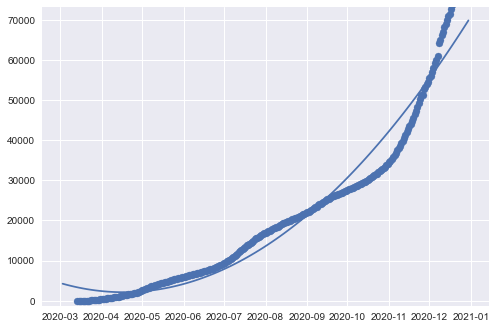

R Squared value is: 0.9615552303948411
152695 cases predicted in Franklin Ohio on 2021-05-05 00:00:00


In [8]:
case = cases_model('2021-05-05', 'Franklin', 'Ohio')

Next we want to calculate the perecent chance of you getting covid. This next csv file has 2019 population info per county

In [150]:
pop_df = pd.read_csv("counties.csv")

search = pop_df.loc[(pop_df['state'] == 'Ohio') & (pop_df['county'] == 'Franklin')]
print(search)

     state    county  pop2019
2103  Ohio  Franklin  1316756


We also want to figure out the total population in 2019 so we can compare that to the state value

In [112]:
total_pop_df = pop_df.loc[pop_df['state'] == pop_df['city']] 
total_pop_df = total_pop_df['pop2019'].sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   state    3193 non-null   object
 1   city     3193 non-null   object
 2   pop2019  3193 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 75.0+ KB
Empty DataFrame
Columns: [state, city, pop2019]
Index: []


In [139]:
def cases_percentage(cases):
    # county percentage 
    if cases[1] != "":
        population = int(pop_df.loc[pop_df['county'] == cases[0]]['pop2019'])
        number_of_cases = int(cases[-1])
        location = "the county compared to the population of the county"
    # state compared to nation percentage
    else:
        population = total_pop_df
        number_of_cases = int(cases[-1])
        location = "the state compared to total population of the nation"
    percentage = round((number_of_cases / population * 100),2)
    print(str(percentage) + "% of the population in the " + location + " have COVID on that specified date")
    return percentage
    
    
case_percent = cases_percentage(case)
    

TypeError: cannot convert the series to <class 'int'>

In [115]:
from fractions import Fraction

def cases_fraction(percent):
    numerator = int((round(percent, 0) / 100) * 1000)
    if numerator == 0:
        numerator = 1 
        
    frac = Fraction(numerator, 1000)
    print("About " + str(frac) + " people around you will have COVID on specified date")
    return frac
    
cases_fraction(case_percent)

About 1/50 people around you will have COVID on specified date


Fraction(1, 50)

Series([], Name: pop2019, dtype: int64)
